# time

In [1]:
import pymongo
import numpy as np
import pandas as pd
import json

import datetime

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (10,8)})    

def toSec(data_file,beginYear = -1):
    if beginYear == -1:
        beginYear = data_file["year"]
    dt = datetime.datetime(data_file["year"]+ 1911, data_file["month"], data_file["day"], data_file["hour"] ,data_file["minute"])
    delta = dt - datetime.datetime(beginYear + 1911, 1, 1,0,0,0)
    return delta.total_seconds()/60

def getSec(month = 0, day = 0, hour = 0, minute = 0):
    return ((month * 29.53059 + day) * 24 + hour) * 60 + minute

def is_leap_year(year):
    """Determine whether a year is a leap year."""
    year = year + 1911
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)
    
mapping = {
    1:31, 2:28,3:31, 4:30,5:31, 6:30,7:31,8:31, 9:30, 10:31,11:30 ,12:31,
}

not_leap_year = [0,0]
for k,v in mapping.items():
    not_leap_year.append(not_leap_year[k] + v)

not_leap_year = np.array(not_leap_year)

yearOffset = [0]
for i in range(107,111):
    yearOffset.append(toSec({
        'year':i,
        'month':12,
        'day':31,
        'hour':23,
        'minute':59,
    },107) + 1)


## load from db

In [ ]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["mydatabase"]
colList = np.array(["107_TrafficAccident","108_TrafficAccident","109_TrafficAccident","110_TrafficAccident"])
a = []
for col in colList:
    for row in mydb[col].find( {},{'_id':0}):
        row['lng'] = row['lnglat'][0]
        row['lat'] = row['lnglat'][1]
        del row['lnglat']
        a.append(row)
        
df = pd.read_json(json.dumps(a))

df['acc_minutes'] = ((  df['year'].apply(lambda x:is_leap_year(x)).apply(lambda x: 1 if x else 0) * \
                    df['month'].apply(lambda x: 1 if x > 2 else 0 )  + \
                    df['month'].apply(lambda x: not_leap_year[x])  + \
                    df['day']  - 1) * 24 +\
                    df['hour']) * 60 +\
                    df['minute'] + \
                    df['year'].apply(lambda x: yearOffset[x-107])
  
df = df.sort_values(by='acc_minutes')

df = df.reset_index().drop(['index','id'],axis=1)

if False:
    df.to_csv('df.csv')

## from csv

In [2]:
df = pd.read_csv('df.csv')

In [ ]:
sns.displot(df['acc_minutes'],bins = 48,kde = True)

## count data

<AxesSubplot:>

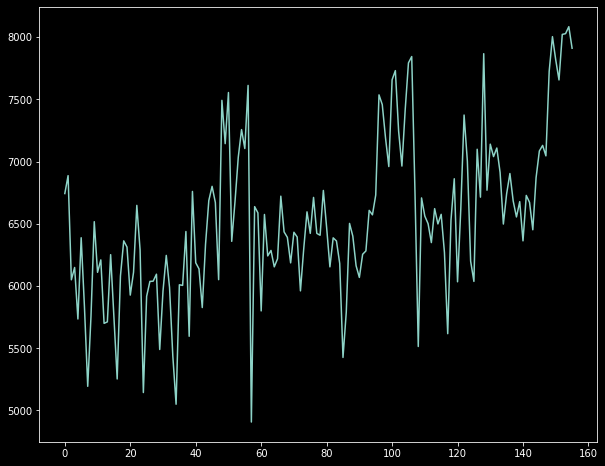

In [49]:
def count(**args):
   return (df['acc_minutes'] / getSec(**args)).apply(lambda x: int(x)).value_counts(sort=False)

def queryCount(query,**args):
   return (df.query(query)['acc_minutes'] / getSec(**args)).apply(lambda x: int(x)).value_counts(sort=False)

# value:count
# x:height
data = count(day = 7)
data = data[:int(len(data) * 0.75)]
#data = queryCount("city == '臺北市'",day = 7)
#plt.bar(x=data.index,height=data.values)
data.plot()

In [52]:
data = data - data.shift(1)
data = data.dropna()

## sub

In [ ]:
data = df['acc_minutes'][1:].reset_index()['acc_minutes'] - df['acc_minutes'][:-1].reset_index()['acc_minutes']
data.describe()

## t, t-1 corr

In [ ]:
pd.plotting.lag_plot(data, lag=1)

## linear regression

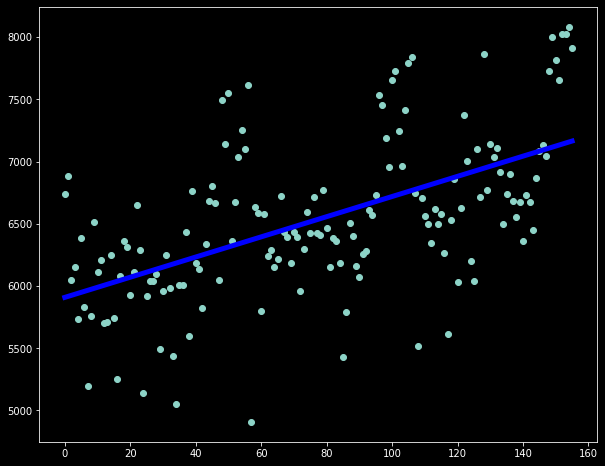

In [6]:
from sklearn.linear_model import LinearRegression
regr=LinearRegression()
regr.fit(np.array(data.index).reshape(-1, 1), data.to_numpy())

pred = regr.predict(np.array(data.index).reshape(-1, 1))
plt.scatter(x=data.index,y=data)
plt.plot(data.index, pred,color='blue',linewidth=5)
plt.show()

In [ ]:
pd.concat([data, data.shift(11)],axis=1).corr()

## auto correlation

d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


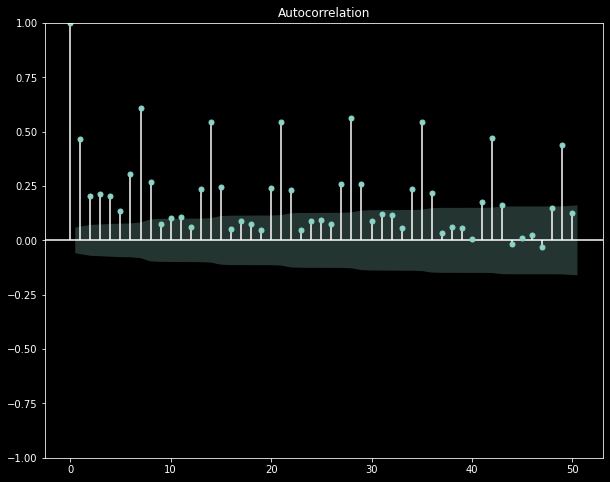

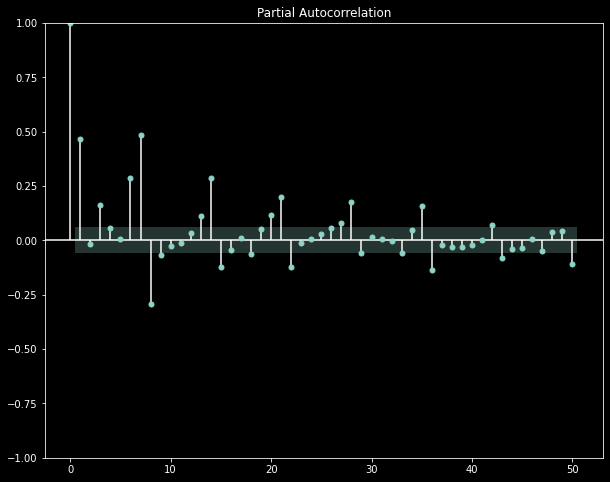

In [15]:
# import the required modules
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
 
# plot the auto correlation
a = plot_acf(data,lags= 50)
b = plot_pacf(data ,lags= 50)

## decompostion

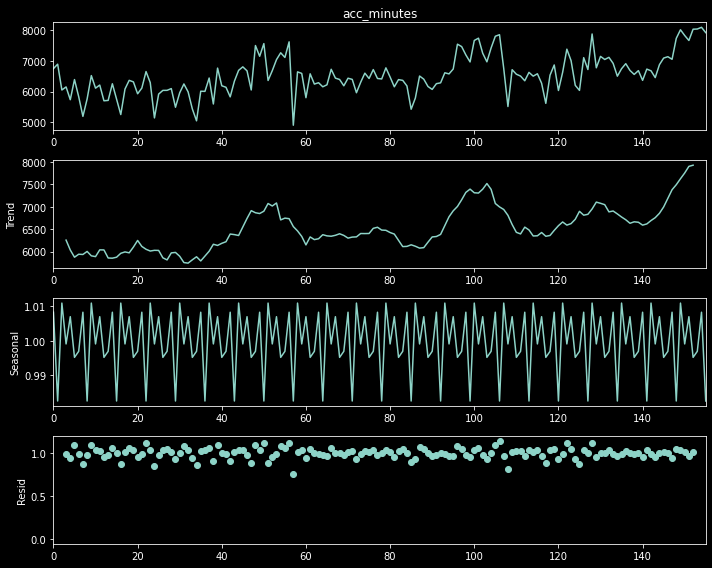

In [50]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(data,period =7,model = 'multiplicative') # ,model = 'multiplicative'
figure = decomposition.plot()
plt.show()

## check stationary

In [53]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test\n================================================")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index = [
        "Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"
    ])
    for key, value in dftest[4].items():
        dfoutput["Criterical Value (%s)"%key] = value

    print(dfoutput)
    print("================================================")  

    if dfoutput[0] < dfoutput[4]:
        print("The data is stationary. (Criterical Value 1%)")  
    elif dfoutput[0] < dfoutput[5]:
        print("The data is stationary. (Criterical Value 5%)") 
    elif dfoutput[0] < dfoutput[6]:
        print("The data is stationary. (Criterical Value 10%)")
    else:
        print("The data is non-stationary, so do differencing!")

adf_test(data)

Results of Dickey-Fuller Test
Test Statistic                -1.018635e+01
p-value                        6.493521e-18
#Lags Used                     3.000000e+00
Number of Observations Used    1.510000e+02
Criterical Value (1%)         -3.474416e+00
Criterical Value (5%)         -2.880878e+00
Criterical Value (10%)        -2.577081e+00
dtype: float64
The data is stationary. (Criterical Value 1%)


## find q、q

In [60]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.api as smt 
from sklearn.metrics import mean_absolute_error, mean_squared_error
for i in range(5,8):
    for o in range(0,3):
        for p in range(0,3):
            mod = ARIMA(data.reset_index().drop('index',axis=1),order = (i,o,p)).fit()
            print(i,o,p,mod.aic)

5 0 0 2356.6951148928615
5 0 1 2358.330744227206


d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


5 0 2 2344.7689674164903
5 1 0 2369.0651855074702
5 1 1 2349.0661760426856


d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


5 1 2 2352.1361534159932
5 2 0 2430.7562120056905


d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


5 2 1 2363.7924495251036


d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5 2 2 2348.5461048979214
6 0 0 2357.156075837971
6 0 1 2358.3091147823443


d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


6 0 2 2346.0276934400517
6 1 0 2370.1876324469813
6 1 1 2349.2913935604447


d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA paramet

6 1 2 2350.490738908602
6 2 0 2417.342553317192
6 2 1 2365.0523516001936


d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


6 2 2 2367.7915289712305
7 0 0 2356.8388178774157
7 0 1 2358.616391886088


d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


7 0 2 2346.7350024426105
7 1 0 2369.517064000677
7 1 1 2349.26187183049


d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA paramet

7 1 2 2352.9190682198446
7 2 0 2414.384944715736
7 2 1 2364.649962757827


d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


7 2 2 2369.0521609854377


In [62]:
data_t = data[:100].reset_index().drop('index',axis=1)

## arima model

d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\User\User\Desktop\SpecialProject\.venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:>

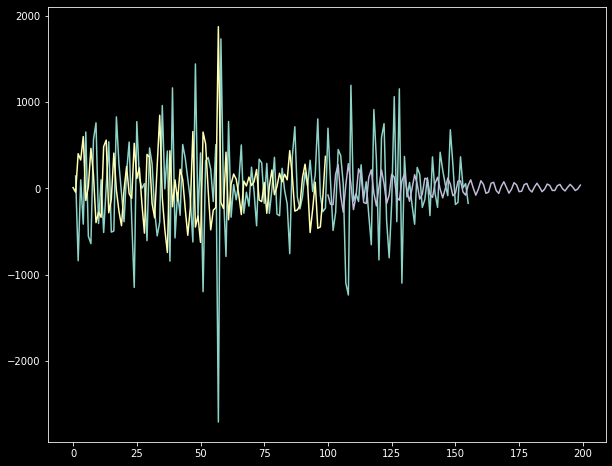

In [64]:
from statsmodels.tsa.arima.model import ARIMA
mod = ARIMA(data_t,order = (5,0,2))
data.plot()
mod.fit().predict().plot()
mod.fit().forecast(steps = 100).plot()

# merge db data to csv

In [ ]:
import pymongo
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["mydatabase"]
colList = ["107_TrafficAccident","108_TrafficAccident","109_TrafficAccident","110_TrafficAccident"]
import pandas as pd
a = []
for col in colList:
    for row in mydb[col].find( {},{'_id':0}):
        row['lng'] = row['lnglat'][0]
        row['lat'] = row['lnglat'][1]
        del row['lnglat']
        a.append(row)
aa = pd.DataFrame(a)
aa.to_csv('data.csv')

# to analysis csv

In [ ]:
import pandas as pd
from routeMap.analyze import utilize
import numpy as np
import json
a = pd.read_csv('./data.csv')
a = a[['city','year','month']].value_counts()
size = 12*4
aa = np.zeros((22,size))
for i,v in a.iteritems():
    aa[utilize.city_list.index(i[0]),(i[1]-107)*12+i[2]-1] = int(v)
pd.DataFrame(aa.astype(int),columns=[f'{2018+int(i/12)}_{i%12+1}' for i in range(size)],index=utilize.city_list).to_csv('./analysis.csv')

In [ ]:
from routeMap.analyze import kde
from routeMap.analyze import utilize
from routeMap.analyze import gi_model
from routeMap.analyze import moransI
import seaborn as sns
import numpy as np
from scipy import stats
t = "23.473432610480064%2C%20120.42930409629508)%2C%20(23.510311407876987%2C%20120.51170155723258"
t = np.array(t.replace("(", "").replace(")", "").split("%2C%20")).astype(float)
bbox = [[t[1], t[0]],[t[3], t[2]]]

In [ ]:
a = utilize.statistics_from_bbox(bbox[0],bbox[1],100)[0]

In [ ]:
aaa = np.array(gi_model.giModel(bbox[0],bbox[1],100).gi)  

In [ ]:
b = utilize.array_to_base64_png(a,alpha=[1 for i in np.linspace(-1,1,256)], show=True)

In [ ]:
b = utilize.array_to_base64_png(aaa,alpha=[1 for i in np.linspace(-1,1,256)], show=True)

In [ ]:
m = np.zeros(a.shape)
dd = 10
for i in range(41):
    for o in range(92):
        ccccc = 0
        for ii in range(i-dd,i+dd+1):
            for oo in range(o-dd,o+dd+1):
                try:
                    m[i,o] = m[i,o] + a[ii,oo]
                    ccccc = ccccc +1
                except:
                    pass
        m[i,o] = m[i,o] / ccccc

ab = a -m
b = utilize.array_to_base64_png(ab ,alpha=[1 if i > -0.5 else 0 for i in np.linspace(-1,1,256)], show=True)
b = utilize.array_to_base64_png(m ,alpha=[1 for i in np.linspace(-1,1,256)], show=True)

print(a.max(),a.min(),a.mean(),a.std())
print(ab.max(),ab.min(),ab.mean(),ab.std())

In [ ]:
ccc = np.array(moransI.moransModel(bbox[0],bbox[1],100).moransI)  
b = utilize.array_to_base64_png(ccc,alpha=[1 for i in np.linspace(-1,1,256)], show=True)

In [ ]:
from routeMap.analyze import kde
from routeMap.analyze import utilize
from routeMap.analyze import gi_model
from routeMap.analyze import moransI
from importlib import reload
import numpy as np
from PIL import Image
reload(kde)
reload(utilize)
reload(gi_model)
reload(moransI)


In [ ]:
from PIL import Image
stack = []
arr2 = []
for i in range(12):
    for o in range(19,-1,-1):
        pass

for i in range(12):
    for o in range(19,-1,-1):   
        print(f'{i}_{o}_1.png')
        img = Image.open(f'./image/{i}_{o}_1.png')
        arr = np.array(img) # 640x480x4 array
        stack.append(arr)

    arr3 = np.vstack(stack)
    stack = []
    arr2.append(arr3)
arr3 = np.hstack(arr2)
im = Image.fromarray(arr3)



im.save("image/mor1.png")

In [ ]:
img = Image.open(f'./image/0_0_1.png')
arr = np.array(img) # 640x480x4 array
for w in range(217):
    arr[216][w] = [0,0,0,256]
    arr[w][216] = [0,0,0,256]
arr

In [ ]:

utilize.array_to_base64_png([[0,0]],show=True,saveAs="test.png")
img = Image.open(f'test.png')
arr = np.array(img) # 640x480x4 array
arr

In [ ]:
lbound = np.array([120.01930, 21.86400])
ubound = np.array([122.1817,  25.468])
tenk = 0.00000901 * 20000


row,col =   np.round(((ubound - lbound)/tenk),1).astype(int)
print(row,col)

for i in range(row):
    for o in range(col):
        img = Image.open(f'image/{i}_{o}_1.png')
        arr = np.array(img) # 640x480x4 array
        lb = lbound + [tenk * i, tenk * o]
        ub = lb + [tenk, tenk]
        moransI.moransModel(lb,ub,100).output(f'{i}_{o}_')
        print(f'{i}_{o}',lb,ub)


In [ ]:
lbound = np.array([120.01930, 21.86400])
ubound = np.array([122.1817,  25.468])
tenk = 0.00000901 * 20000
for i in [1]:
    for o in [6,7]:
        lb = lbound + [tenk * i, tenk * o]
        ub = lb + [tenk, tenk]
        moransI.moransModel(lb,ub,100).output(f'{i}_{o}_')
        print(f'{i}_{o}',lb,ub)

In [ ]:
lbound + np.array([tenk*12,20*tenk])

In [ ]:
row,col =  ((ubound - lbound)/tenk).astype(int)
print(row,col)

In [ ]:
from PIL import Image
  
# Opening the primary image (used in background)
img1 = Image.open(r"./image/6_5_1.png")
  
# Opening the secondary image (overlay image)
img2 = Image.open(r"./image/6_5_2.png")
  
# Pasting img2 image on top of img1 
# starting at coordinates (0, 0)
img1.paste(img2, (0,0), mask = img2)
  
# Displaying the image
img1.show()

In [ ]:
import uuid
uuid.uuid4().hex

In [ ]:
aa = a

In [ ]:
am = np.round(a.moransI,6)
aam = np.round(aa.moransI,6)

for i in range(a.row_max):
    for o in range(a.col_max):
        if aam[i][o] != am[i][o]:
            print(aam[i][o],am[i][o])

In [ ]:
a.output()

In [ ]:
(a.arr - a.avg).min()

In [ ]:
ll,uu =utilize.boundary_city(['臺北市'])
arrr,_,_ = utilize.statistics_from_bbox(ll,uu,100)
b = utilize.array_to_base64_png(arrr,alpha=[1 if i > 0.1 else 0 for i in np.linspace(0,1,256)])

In [ ]:
b = utilize.array_to_base64_png(a.arr,show=True)
b = utilize.array_to_base64_png(a.avg,show=True)
s = a.arr - a.avg/169
b = utilize.array_to_base64_png(s,alpha=[abs(i) for i in np.linspace(-1, 1, 256)],show=True)
b = utilize.array_to_base64_png(a.moransI,alpha=[abs(i) for i in np.linspace(-1, 1, 256)],show=True)